In [1]:
import pm4py
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pickle
import numpy as np
import tqdm
import seaborn as sns
from project_functions import *
from sklearn.model_selection import train_test_split,GridSearchCV, cross_validate
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
log_df = None
with open("data/log_df_filtered.pkl", "rb") as f:
    log_df = pickle.load(f)

print("We have",len(log_df['case:concept:name'].unique()),"cases")

We have 139148 cases


# Dataset
Using three days span hasn't produced any result. We now create the dataset using the firsts two activities that occured as input.

In [3]:

column_names = ['amount', 'article', 'act2', 'delta_time', 'org:resource', 'day','month','vehicleClass','case_duration']

#Structure to create the dataframe
temp_list=[]
temp_row = [len(column_names)]

#iter on all subdf of the same case
for case_id, group in log_df.groupby('case:concept:name'):
    temp_row = ['missing' for i in range(len(column_names))]
    start_ts = group['time:timestamp'].min()
    
    #take amount where case:concept:name = Create Fine
    temp_row[0] = group[group['concept:name'] == 'Create Fine']['amount'].values[0]
    #take article
    temp_row[1] = str(int(group[group['concept:name'] == 'Create Fine']['article'].values[0]))
    #take resource
    temp_row[4] = group[group['concept:name'] == 'Create Fine']['org:resource'].values[0]
    #vehicle class
    temp_row[7] = group[group['concept:name'] == 'Create Fine']['vehicleClass'].values[0]
    #print(amount, article, res, vc)
    
    #get day and month
    temp_row[5] = group['time:timestamp'].min().day
    temp_row[6] = group['time:timestamp'].min().month
    
    #get duration (expressed in days)
    #using -1 as index, to fill the last positzion of the list
    case_duration = (group['time:timestamp'].max() - group['time:timestamp'].min()).total_seconds()/ (24 * 60 * 60)
    if case_duration < 7:
        temp_row[-1]= 'short'
    elif case_duration < 3*30: #3 months
        temp_row[-1]= 'medium-short'
    elif case_duration <= 365: #1 year
        temp_row[-1]= 'medium-long'
    else:
        temp_row[-1]= 'long'
        
    for count, (index, row) in enumerate(group.iterrows()):
        if count == 0:
            continue
        
        temp_row[2]= row['concept:name']
        temp_row[3] = (row['time:timestamp'] - start_ts).total_seconds() / (24 * 60 * 60)
        
        break

    #append the row to the list only if the second activity is within 3 months, this is to avoid unbalanced dataset
    if (temp_row[3] < 90):
        temp_list.append(temp_row)

    
dataset = pd.DataFrame(temp_list,columns=column_names)
dataset


    

amount article       act2  delta_time org:resource  day  month  \
0        36.0     157    Payment         1.0          537   20      3   
1        36.0     157    Payment         3.0          537   20      3   
2        22.0       7    Payment         6.0          537   22      3   
3        36.0     157    Payment         4.0          537   22      3   
4        36.0     157    Payment        19.0          537   22      3   
...       ...     ...        ...         ...          ...  ...    ...   
89414   131.0     142  Send Fine        48.0           25    7      9   
89415   131.0     142  Send Fine        48.0           25    7      9   
89416   131.0     142  Send Fine        48.0           25    7      9   
89417   131.0     142  Send Fine        48.0           25    7      9   
89418   131.0     142  Send Fine        48.0           25    7      9   

      vehicleClass case_duration  
0                A         short  
1                A         short  
2                A         short  
3                A         short  
4                A  medium-short  
...            ...           ...  
89414            A          long  
89415            A  medium-short  
89416            M          long  
89417            A          long  
89418            A          long  

[89419 rows x 9 columns]

In [4]:
#print how many rows we have for each class
print(dataset['case_duration'].value_counts())


case_duration
long            34493
short           30478
medium-short    17197
medium-long      7251
Name: count, dtype: int64


# Training

In [8]:
X = dataset.iloc[:, :-1]  # All columns except the last one
y = dataset.iloc[:, -1]   # The last column


#get X but only wit article and act2 columns

# Identifica le colonne categoriali e numerich
categorical_cols = X[['article', 'act2', 'org:resource', 'vehicleClass']].columns
numerical_cols = X[['amount', 'delta_time', 'day', 'month']].columns
#categorical_cols = X.select_dtypes(include=['object', 'category']).columns
#numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

print(type(categorical_cols))

# Crea i transformer per le colonne categoriali e numeriche
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Applica i transformer al dataset
X = preprocessor.fit_transform(X)

ohe = preprocessor.named_transformers_['cat']
encoded_col_names = ohe.get_feature_names_out(categorical_cols)
all_col_names = numerical_cols.tolist() + encoded_col_names.tolist()


clf = DecisionTreeClassifier()

# hyper param per grid search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

#Perform grid search optimization
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

grid_search.fit(X, y)
best_clf = grid_search.best_estimator_

# Perform cross-validation with the best estimator
cv_results = cross_validate(best_clf, X, y, cv=5, scoring=scoring)

# Calculate average scores
accuracy = cv_results['test_accuracy'].mean()
precision = cv_results['test_precision'].mean()
recall = cv_results['test_recall'].mean()
f1 = cv_results['test_f1'].mean()

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Cross-validated Accuracy: {accuracy * 100:.2f}%')
print(f'Cross-validated Precision: {precision * 100:.2f}%')
print(f'Cross-validated Recall: {recall * 100:.2f}%')
print(f'Cross-validated F1-score: {f1 * 100:.2f}%')


<class 'pandas.core.indexes.base.Index'>


/Users/alessandro/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alessandro/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alessandro/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2, 'splitter': 'best'}
Cross-validated Accuracy: 89.49%
Cross-validated Precision: 84.03%
Cross-validated Recall: 89.49%
Cross-validated F1-score: 86.20%


In [6]:
from sklearn import tree
plt.figure(figsize=(200,200))
plot_tree(best_clf, filled=True, feature_names=all_col_names, rounded=True)
plt.show()


## Feature importance

/var/folders/_f/k63ns_v15qv4kfpd87ckc8lm0000gn/T/ipykernel_66506/2554736812.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')


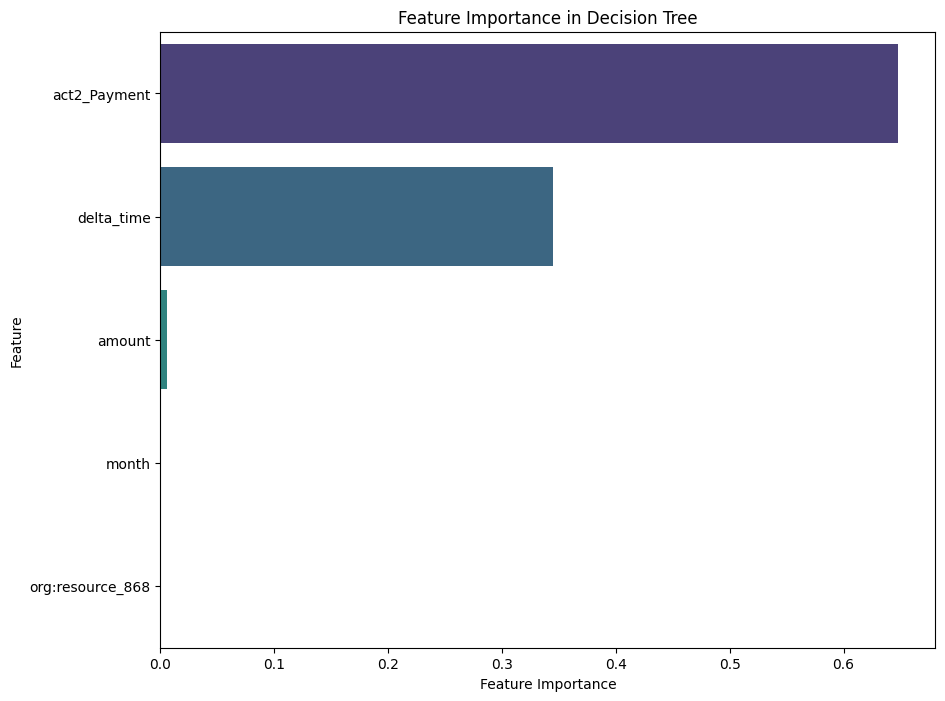

In [7]:

# Get feature importances
importances = best_clf.feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({
    'Feature': all_col_names,
    'Importance': importances
})

# Separate features with importance < 0.01
low_importance_features = set(feature_importances[feature_importances['Importance'] < 0.001]['Feature'])

# Filter out low importance features
feature_importances = feature_importances[feature_importances['Importance'] >= 0.0001]

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Decision Tree')
plt.show()
